<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#aten算子名称" data-toc-modified-id="aten算子名称-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>aten算子名称</a></span></li><li><span><a href="#aten算子到onnx算子" data-toc-modified-id="aten算子到onnx算子-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>aten算子到onnx算子</a></span></li></ul></div>

在前几篇中，我们了解了torch如何通过trace或者script两种方式将nn.Module转换为nn.ScriptModel，并且通过代码示例解释了两者之间的区别。此外，还简单说明了onnx算子和如何使用torch.onnx.export将nn.Module转换为onnx算子，并且通过onnxruntime运行模型。在这一篇我们将补全ScriptModel到onnx算子的线，即学习ScriptModel中的aten算子如何映射到onnx算子上。

## aten算子名称

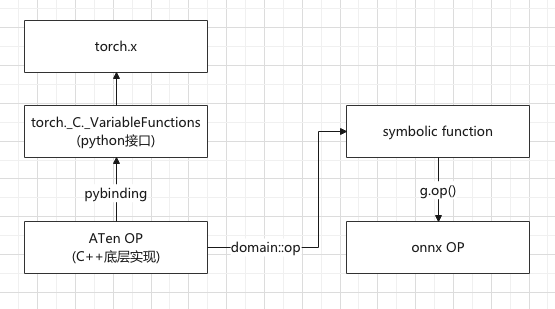

每一个底层的aten算子都会对应一个算子名称，比如torch.add对应的名称是aten::add，这个名称是在add算子的底层定义中规定的，这个我们在torch源码阅读中有看看到过：
```c++
#aten/src/ATen/ops/add_ops.h
struct TORCH_API add_Tensor {
  // 函数在cpp的schema
  using schema = at::Tensor (const at::Tensor &, const at::Tensor &, const at::Scalar &);
  using ptr_schema = schema*;
  // 在这里定义了算子对应的名称是 aten::add
  STATIC_CONSTEXPR_STR_INL_EXCEPT_WIN_CUDA(name, "aten::add")
  STATIC_CONSTEXPR_STR_INL_EXCEPT_WIN_CUDA(overload_name, "Tensor")
  // 函数在python的schema
  STATIC_CONSTEXPR_STR_INL_EXCEPT_WIN_CUDA(schema_str, "add.Tensor(Tensor self, Tensor other, *, Scalar alpha=1) -> Tensor")
  static at::Tensor call(const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha);
  static at::Tensor redispatch(c10::DispatchKeySet dispatchKeySet, const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha);
};
```

不同输入参数的add函数其实对应的都是同一个aten::add名称，比如：
```c++
struct TORCH_API add_out {
  using schema = at::Tensor & (const at::Tensor &, const at::Tensor &, const at::Scalar &, at::Tensor &);
  using ptr_schema = schema*;
  // See Note [static constexpr char* members for windows NVCC]
  STATIC_CONSTEXPR_STR_INL_EXCEPT_WIN_CUDA(name, "aten::add")
  STATIC_CONSTEXPR_STR_INL_EXCEPT_WIN_CUDA(overload_name, "out")
  STATIC_CONSTEXPR_STR_INL_EXCEPT_WIN_CUDA(schema_str, "add.out(Tensor self, Tensor other, *, Scalar alpha=1, Tensor(a!) out) -> Tensor(a!)")
  static at::Tensor & call(const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha, at::Tensor & out);
  static at::Tensor & redispatch(c10::DispatchKeySet dispatchKeySet, const at::Tensor & self, const at::Tensor & other, const at::Scalar & alpha, at::Tensor & out);
};

struct TORCH_API add_Scalar {
  using schema = at::Tensor (const at::Tensor &, const at::Scalar &, const at::Scalar &);
  using ptr_schema = schema*;
  // See Note [static constexpr char* members for windows NVCC]
  STATIC_CONSTEXPR_STR_INL_EXCEPT_WIN_CUDA(name, "aten::add")
  STATIC_CONSTEXPR_STR_INL_EXCEPT_WIN_CUDA(overload_name, "Scalar")
  STATIC_CONSTEXPR_STR_INL_EXCEPT_WIN_CUDA(schema_str, "add.Scalar(Tensor self, Scalar other, Scalar alpha=1) -> Tensor")
  static at::Tensor call(const at::Tensor & self, const at::Scalar & other, const at::Scalar & alpha);
  static at::Tensor redispatch(c10::DispatchKeySet dispatchKeySet, const at::Tensor & self, const at::Scalar & other, const at::Scalar & alpha);
};
```

## aten算子到onnx算子

aten算子到onnx算子的映射通过一个称为符号函数的函数定义，比如aten::add算子的入参与onnx::Add算子入参的对应、位置的对应、参数的转换等。前面我们也说过onnx算子存在不同的opset版本，同一个算子在不同版本中的映射方式也是通过符号函数确认。

符号函数的注册就在`torch/onnx/`目录下的`symbolic_opsetx.py`文件中实现，不同opset版本对应一个`symbolic_opsetx.py`文件。pytorch-1.13.1中使用opset9作为最小的支撑版本，因为这个版本包括了大多数基础算子。我们以`symbolic_opset9.py`说明aten::add算子符号函数的注册逻辑。

```c++
@_onnx_symbolic("aten::add")
@_beartype.beartype
def add(g: jit_utils.GraphContext, self, other, alpha=None):
    if symbolic_helper._is_value(self) and symbolic_helper._is_tensor_list(self):
        return symbolic_helper._onnx_opset_unsupported_detailed(
            "Add", 9, 11, "Add between list of tensors not supported", self
        )
    if alpha and symbolic_helper._scalar(symbolic_helper._maybe_get_scalar(alpha)) != 1:
        other = g.op("Mul", other, alpha)
    return g.op("Add", self, other)
```

`def add`就是一个符号函数，每一个符号函数的第一个参数固定为g，参数类型为`jit_utils.GraphContext`，剩下的参数和参数位置需要与在存根文件`torch/_C/_VariableFunctions.pyi`中定义的一致，其实也就是与上面展示的c++层面`add_Tensor`结构体中的函数schema一致。

符号函数首先判断传入的参数self是否为张量列表，如果是则返回错误。接着检查alpha是否传入并且是否为1，如果不是则将其乘以other张量。这个涉及到torch.add这个函数的内部实现，其实该函数内部实现为：`c = a + alpha * b`，默认alpha为1。这里需要注意，传入onnx::Mul算子的参数顺序需要与onnx::Mul算子的定义对应。最后，再将结果传入onnx::Add函数。

`g.op`最终对应的逻辑是创建node，并且将这个node插入到整个graph中：
```c++
# torch/onnx/_internal/jit_utils.py
jit_utils.GraphContext

---> 

def op(
        self,
        opname: str,
        *raw_args: Union[torch.Tensor, _C.Value],
        outputs: int = 1,
        **kwargs,
    )
    
--> 

def _add_op(
    graph_context: GraphContext,
    opname: str,
    *args: Union[torch.Tensor, _C.Value],
    outputs: int = 1,
    **kwargs,
)

--> 

def _create_node(
    graph_or_block: Union[_C.Graph, _C.Block],
    domain_op: str,
    inputs: Sequence,
    attributes: dict,
    params_dict: dict,
    opset_version: int,
    n_outputs: int,
    shape_inference: bool = True,
):
    if isinstance(graph_or_block, _C.Graph):
        graph = graph_or_block
        node = graph.create(domain_op, inputs, n_outputs)
        node = graph.insertNode(node)

    ...


    if shape_inference:
        _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
```

这个符号函数如何进行注册，就需要通过装饰器`_onnx_symbolic("aten::add")`实现。在symbolic_opset9.py文件中该装饰器传入的opset就是9：
```
_onnx_symbolic = functools.partial(registration.onnx_symbolic, opset=9)
```

onnx_symbolic其实就是一个dict映射，在给定输入参数的情况下，对于同一个算子名称，根据不同版本的opset注册对应的符号函数：
```c++
# torch/onnx/_internal/registration.py
def onnx_symbolic(
    name: str,
    opset: Union[OpsetVersion, Sequence[OpsetVersion]],
    decorate: Optional[Sequence[Callable]] = None)
 

class SymbolicRegistry:
	def register(
        self, name: str, opset: OpsetVersion, func: Callable, custom: bool = False
    ) -> None:
    pass

self._registry: Dict[str, _SymbolicFunctionGroup] = {}

```